In [1]:
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm_notebook
import os

In [2]:
english_meta = pd.read_csv('./data/en/validated.tsv', sep='\t')
spanish_meta = pd.read_csv('./data/es/validated.tsv', sep='\t')
chinese_meta = pd.read_csv('./data/zh-CN/validated.tsv', sep='\t')

In [3]:
import IPython.display as ipd
ipd.Audio('./data/zh-CN/clips/common_voice_zh-CN_18646658.mp3')

In [4]:
chinese_meta

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,0697ece1f99a08477906d0f3b4e74e1d6ffca76c20a7db...,common_voice_zh-CN_18646658.mp3,局部干涩的例子包括有口干、眼睛干燥、及阴道干燥。,2,1,NaN,NaN,NaN
1,077c6d812d0152245b7577ae430775781d98306ed0d264...,common_voice_zh-CN_18776118.mp3,嘉靖三十八年，登进士第三甲第二名。,2,1,NaN,NaN,NaN
2,0bdcd4f3d4450cd23bd4c47f46d645b0e797b083e3f158...,common_voice_zh-CN_18840501.mp3,为了惩罚西扎城和塞尔柱的结盟，盟军在抵达后将外城烧毁。,2,0,NaN,NaN,NaN
3,3b7575fdad7077cfd29a23938fc0bd6c284245b38f92f9...,common_voice_zh-CN_18832787.mp3,滨江县先后隶属于吉林省西北路道和滨江道。,2,1,NaN,NaN,NaN
4,3c288ef58ce0780634a972e1b92b04c444bfa963dfcb2d...,common_voice_zh-CN_18774708.mp3,大使馆全年都为各类政治人物和公众举办了许多活动，包括庆祝以色列独立日独立日。,2,0,twenties,male,440000.0
5,3d28475fd46db162ffa6a79edea556c143a9b0e53f6415...,common_voice_zh-CN_18903199.mp3,感冒茶起源于中国岭南一带。,2,0,NaN,NaN,NaN
6,48292f36099f3b7b3543e24b1f62aa69d71e76ad1bb1dd...,common_voice_zh-CN_18653869.mp3,福茨斯普林斯是位于美国加利福尼亚州科卢萨县的一个非建制地区。,2,1,NaN,NaN,NaN
7,48bf3483a222100483ba249a1fc42a116bd2c530070afc...,common_voice_zh-CN_18733748.mp3,当她去世时，讣告也称她为「永不沉没的布朗夫人」。,2,1,NaN,NaN,NaN
8,4f1b77f2d3f6dd0deaa3355f0c6105cc36d80feee1dd0e...,common_voice_zh-CN_18817154.mp3,有论者批评词中出现现代通俗口语「劲歌」，与整首歌的古典风格格格不入。,2,1,NaN,NaN,NaN
9,57763d3cf9178950a1cf76212d3fd3f4bf8359787715e6...,common_voice_zh-CN_18524189.mp3,正巧母亲往外探头,2,0,NaN,NaN,NaN


In [5]:
chinese_meta[pd.notna(chinese_meta['gender'])][['client_id','gender']].groupby('gender').count()

,client_id
gender,
female,32
male,4909


In [11]:
def sample_split(df, records=4000):
    sample = df[df['gender']=='male'].sort_values('up_votes', ascending=False).head(records)[['path']]
    sample['language'] = sample['path'].apply(lambda x: x.split('_')[2]) # add label
    sample = sample.sample(frac=1).reset_index(drop=True) # randomise
    split_1 = int(0.6*records)
    split_2 = int(0.8*records)
    return sample.iloc[0:split_1],\
           sample.iloc[split_1:split_2],\
           sample.iloc[split_2:records] # returns train, test, valid

In [17]:
from os.path import isfile
if isfile('./train.csv') and isfile('./validation.csv') and isfile('./test.csv'):
    train = pd.read_csv('./train.csv')
    test = pd.read_csv('./test.csv')
    valid = pd.read_csv('./validation.csv')
else:
    en_train, en_test, en_valid = sample_split(english_meta)
    es_train, es_test, es_valid = sample_split(spanish_meta)
    cn_train, cn_test, cn_valid = sample_split(chinese_meta)
    train = pd.concat([en_train, es_train, cn_train])
    test = pd.concat([en_test, es_test, cn_test])
    valid = pd.concat([en_valid, es_valid, cn_valid])
    train.to_csv('./train.csv', index=False)
    test.to_csv('./test.csv', index=False)
    valid.to_csv('./validation.csv', index=False)

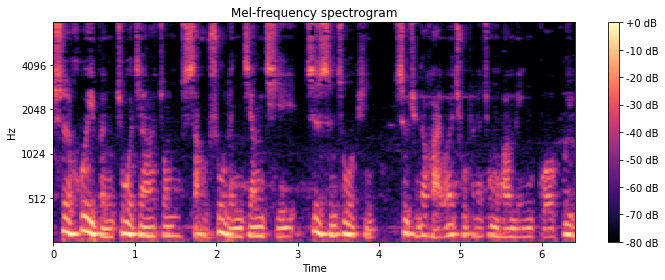

In [19]:
y, sr = librosa.load('./data/zh-CN/clips/common_voice_zh-CN_18772619.mp3')
yt, index = librosa.effects.trim(y, top_db=10)
librosa.feature.melspectrogram(y=yt, sr=sr)

# Passing through arguments to the Mel filters
# S = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=128, fmin=20, fmax=8000)
S = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=224, fmin=20, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)


import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
S_dB = librosa.power_to_db(S, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmin=20, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [20]:
from skimage import io
from sklearn.preprocessing import MinMaxScaler

def scale(input_array, mini, maxi):
    scaler = MinMaxScaler(feature_range=(mini, maxi))
    return scaler.fit_transform(input_array)

def spectrogram_image(in_file, out_file, n_mels=224):
    y, sr = librosa.load(in_file) # load file
    yt, index = librosa.effects.trim(y, top_db=10) # trim file
    
    # use log-melspectrogram
    S = librosa.feature.melspectrogram(y=yt, sr=sr, n_mels=n_mels, fmin=20, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # RGB grayscale
    img = scale(S_dB, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0)
    img = 255-img
    assert len(img[img < 0]) == 0, "sub zero"
    assert len(img[img > 255]) == 0, "greater than 255"

    # save as PNG
    io.imsave(out_file, img)

In [21]:
from parallel import batch_multi

train_tuple_list = [(row.language, row.path) for index, row in train.iterrows()]
test_tuple_list = [(row.language, row.path) for index, row in test.iterrows()]
valid_tuple_list = [(row.language, row.path) for index, row in valid.iterrows()]

def create_melspect_img(lang_path_tuple_list, dataset_type):
    for tup_ in lang_path_tuple_list:
        language = tup_[0]   
        path = tup_[1]
        in_file = os.path.join("./data", language, "clips", path)
        out_file = os.path.join(f"./data/{dataset_type}-melspectogram", language, path.split('.')[0]+".png")
        spectrogram_image(in_file=in_file, out_file=out_file)

In [22]:
batch_multi(test_tuple_list, create_melspect_img, batch_size=20, results=False, dataset_type='test')

In [23]:
batch_multi(valid_tuple_list, create_melspect_img, batch_size=20, results=False, dataset_type='validation')

In [24]:
batch_multi(train_tuple_list, create_melspect_img, batch_size=20, results=False, dataset_type='train')

In [20]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [25]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.utils import np_utils
from sklearn.datasets import load_files
import numpy as np

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train-melspectogram')
valid_files, valid_targets = load_dataset('data/validation-melspectogram')
test_files, test_targets = load_dataset('data/test-melspectogram')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0).astype('float32')/255

def paths_to_tensor(img_paths):
    list_of_tensors = tqdm_notebook([path_to_tensor(img_path) for img_path in img_paths])
    return np.vstack(list_of_tensors)

# calculate the image input. you will learn more about how this works the project!
train_img_input = preprocess_input(paths_to_tensor(train_files))
valid_img_input = preprocess_input(paths_to_tensor(valid_files))
test_img_input = preprocess_input(paths_to_tensor(test_files))

print(train_img_input.shape)

Using TensorFlow backend.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(7200, 224, 224, 3)


In [26]:
from keras.applications.resnet50 import ResNet50
ResNet50_model = ResNet50(include_top=False)
ResNet50_model.summary()

W1107 12:52:09.694106 4548474304 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1107 12:52:09.761285 4548474304 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1107 12:52:09.790640 4548474304 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1107 12:52:09.824891 4548474304 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1107 12:52:09.826007 4548474304 deprecat

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [27]:
train_bottleneck = ResNet50_model.predict(train_img_input)

In [28]:
valid_bottleneck = ResNet50_model.predict(valid_img_input)

In [29]:
test_bottleneck = ResNet50_model.predict(test_img_input)

In [30]:
train_bottleneck.shape

(7200, 7, 7, 2048)

In [31]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_bottleneck.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
# model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
#                         input_shape=train_bottleneck.shape[1:]))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(10, activation='softmax'))

model.summary()

W1107 13:08:23.524156 4548474304 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
__________

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

W1107 13:08:23.839118 4548474304 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_bottleneck, train_targets, 
          validation_data=(valid_bottleneck, valid_targets),
          epochs=100, batch_size=50, callbacks=[checkpointer], verbose=1)

W1107 13:08:24.000617 4548474304 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7200 samples, validate on 2400 samples
Epoch 1/100
7200/7200 [==============================] - 9s 1ms/step - loss: 1.1208 - acc: 0.3379 - val_loss: 1.0675 - val_acc: 0.3733

Epoch 00001: val_loss improved from inf to 1.06750, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 2/100
7200/7200 [==============================] - 4s 541us/step - loss: 1.0689 - acc: 0.4143 - val_loss: 1.0110 - val_acc: 0.5088

Epoch 00002: val_loss improved from 1.06750 to 1.01101, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 3/100
7200/7200 [==============================] - 4s 496us/step - loss: 1.0395 - acc: 0.4506 - val_loss: 0.9971 - val_acc: 0.5288

Epoch 00003: val_loss improved from 1.01101 to 0.99714, saving model to saved_models/weights.best.ResNet50.hdf5
Epoch 4/100
7200/7200 [==============================] - 3s 464us/step - loss: 1.0325 - acc: 0.4622 - val_loss: 0.9953 - val_acc: 0.5229

Epoch 00004: val_loss improved from 0.99714 to 0.99528, saving model t

7200/7200 [==============================] - 4s 501us/step - loss: 0.9542 - acc: 0.5436 - val_loss: 0.9170 - val_acc: 0.5654

Epoch 00039: val_loss did not improve from 0.90157
Epoch 40/100
7200/7200 [==============================] - 4s 516us/step - loss: 0.9515 - acc: 0.5511 - val_loss: 0.9074 - val_acc: 0.5808

Epoch 00040: val_loss did not improve from 0.90157
Epoch 41/100
7200/7200 [==============================] - 4s 506us/step - loss: 0.9478 - acc: 0.5486 - val_loss: 0.9034 - val_acc: 0.5800

Epoch 00041: val_loss did not improve from 0.90157
Epoch 42/100
7200/7200 [==============================] - 4s 515us/step - loss: 0.9506 - acc: 0.5476 - val_loss: 0.9198 - val_acc: 0.5892

Epoch 00042: val_loss did not improve from 0.90157
Epoch 43/100
7200/7200 [==============================] - 4s 502us/step - loss: 0.9528 - acc: 0.5424 - val_loss: 0.9027 - val_acc: 0.5954

Epoch 00043: val_loss did not improve from 0.90157
Epoch 44/100
7200/7200 [==============================] - 3s 42

In [34]:
model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [35]:
predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_bottleneck]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 58.3750%


In [38]:
from sklearn.metrics import confusion_matrix
testy = []
for ray in test_targets:
    for i, el in enumerate(ray):
        if el==1:
            testy.append(i)
confusion_matrix(testy, predictions, labels=[0, 1, 2])

array([[299, 290, 211],
       [135, 545, 120],
       [100, 143, 557]])

In [39]:
language_mapping = {
    0: 'zh-CN',
    1: 'en',
    2: 'es'
}

error_list = []
correct_list = []


for i, test_path in enumerate(test_files):
    if predictions[i] != testy[i]:
        error_list.append((test_path, language_mapping[testy[i]], language_mapping[predictions[i]]))
    else:
        correct_list.append((test_path, language_mapping[testy[i]], language_mapping[predictions[i]]))

In [48]:
from PIL import Image

okay_list = []

h_w_error_list = []
for i in error_list:
    im = Image.open(i[0])
    width, height = im.size
    h_w_error_list.append((i[0],i[1],i[2],width,height))
    if width >= 112:
        okay_list.append(i[0])

h_w_correct_list = []
for i in correct_list:
    im = Image.open(i[0])
    width, height = im.size
    h_w_correct_list.append((i[0],i[1],i[2],width,height))
    if width >= 112:
        okay_list.append(i[0])

In [49]:
from statistics import mean, median, mode, stdev

error_widths = [tup_[3] for tup_ in h_w_error_list]
correct_widths = [tup_[3] for tup_ in h_w_correct_list]

print("mean error width {}".format(mean(error_widths)))
print("mean correct width {}".format(mean(correct_widths)))
print("median error width {}".format(median(error_widths)))
print("median correct width {}".format(median(correct_widths)))
print("stdev error width {}".format(stdev(error_widths)))
print("stdev correct width {}".format(stdev(correct_widths)))
print("max error width {}".format(max(error_widths)))
print("max correct width {}".format(max(correct_widths)))
print("min error width {}".format(min(error_widths)))
print("min correct width {}".format(min(correct_widths)))

mean error width 120.50750750750751
mean correct width 148.79728765167738
median error width 112
median correct width 126
stdev error width 59.87426449478337
stdev correct width 86.27496917949972
max error width 543
max correct width 395
min error width 5
min correct width 14


In [50]:
len(okay_list)


1296

In [43]:
predictions

[2,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 0,
 2,
 1,
 0,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 0,
 1,
 1,
 2,


In [144]:
testy

[2,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 2,
 2,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
